The code loads SST anomalies data from last tutorial (saved in SST_anomalies_data.mat) then load .nc file of gridded monthly temperature data for BC.  Period: Jan 1979 to July 2017.  All the data pre-processing is done below

In [168]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

In [51]:
#load SST data from .csv file and check it out; rows are months, columns are locations
dataSST = pd.read_csv('SST_anomalies_data.csv',header=None)
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dataSST.head()

,0,1,2,3,4,5,6,7,8,9,...,3905,3906,3907,3908,3909,3910,3911,3912,3913,3914
0,-0.12308,-0.12084,-0.12139,-0.12105,-0.13158,-0.15349,-0.176680,-0.178460,-0.147430,-0.113170,...,0.144570,0.091902,0.046698,0.024065,0.004118,-0.024684,-0.063019,-0.10894,-0.13892,-0.16505
1,-0.17330,-0.16945,-0.17073,-0.16849,-0.17042,-0.17796,-0.187190,-0.193050,-0.185620,-0.174880,...,0.112990,0.022551,-0.063413,-0.117790,-0.161240,-0.204050,-0.250380,-0.30163,-0.33831,-0.37024
2,-0.23927,-0.22003,-0.20046,-0.17401,-0.14145,-0.10520,-0.067116,-0.054451,-0.068909,-0.090536,...,0.098546,-0.001382,-0.107230,-0.191060,-0.261070,-0.311620,-0.346080,-0.37701,-0.40022,-0.41632
3,-0.30643,-0.29158,-0.26821,-0.23386,-0.19164,-0.14981,-0.113170,-0.102410,-0.114450,-0.122130,...,0.039214,-0.047552,-0.130820,-0.189120,-0.236900,-0.282530,-0.330870,-0.36545,-0.38047,-0.37156
4,-0.31070,-0.31951,-0.30628,-0.27171,-0.23147,-0.20701,-0.200140,-0.209410,-0.228770,-0.236770,...,-0.118960,-0.149970,-0.178420,-0.200660,-0.222210,-0.249920,-0.284700,-0.30338,-0.30612,-0.27401


In [10]:
#open netcdf file of temperature over BC

filename = 'T_monthly_Canada_1979_2017_ERA_Interim.nc'
dataERA = Dataset(filename)

lonERA = dataERA.variables['longitude'][:] #in degrees E
latERA = dataERA.variables['latitude'][:] #in degrees N
timeERA = dataERA.variables['time'][:] #in hours since year 1900... not a great unit, but it's what ERA comes in
T = dataERA.variables['t2m'] #in K

In [106]:
#reformat data from 3D to 2D, where rows are grid points, columns are months

T2d = np.empty((np.shape(T)[1]*np.shape(T)[2],np.shape(T)[0]))
for ii in range(np.shape(T)[0]):
    T2d[:,ii] = np.reshape(T[ii],(np.shape(T)[1]*np.shape(T)[2],))

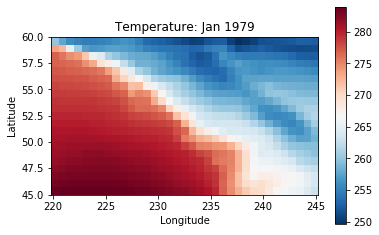

In [50]:
#plot temp over whole domain Jan 1979

lonERAmin = np.min(lonERA)
lonERAmax = np.max(lonERA)
latERAmin = np.min(latERA)
latERAmax = np.max(latERA)
T_extent = [lonERAmin,lonERAmax,latERAmin,latERAmax]
plt.imshow(np.asarray(np.squeeze(T[0,:,:])), extent=T_extent,cmap = 'RdBu_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Temperature: Jan 1979')
plt.colorbar()


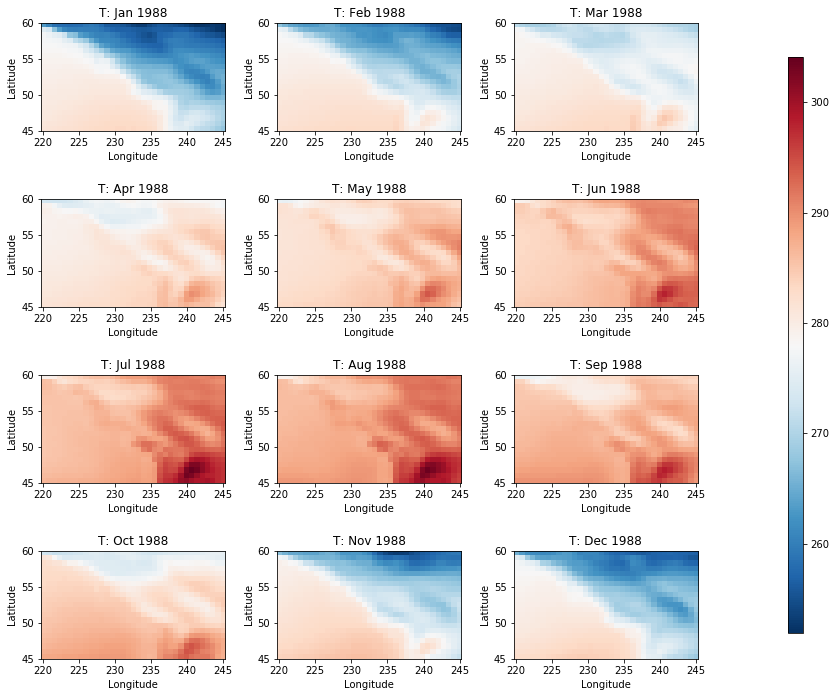

In [80]:
#plot temp for each month in 1988, since this year had a strong La Nina event

vmin = np.min([T[12*9+month,:,:] for month in range(12)])
vmax = np.max([T[12*9+month,:,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    #ax.set_axis_off()
    im = ax.imshow(np.asarray(np.squeeze(T[12*9+month,:,:])), extent=T_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('T: ' + months[month] +' 1988')
    #plt.colorbar()
    plt.tight_layout()
    month+=1
    
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

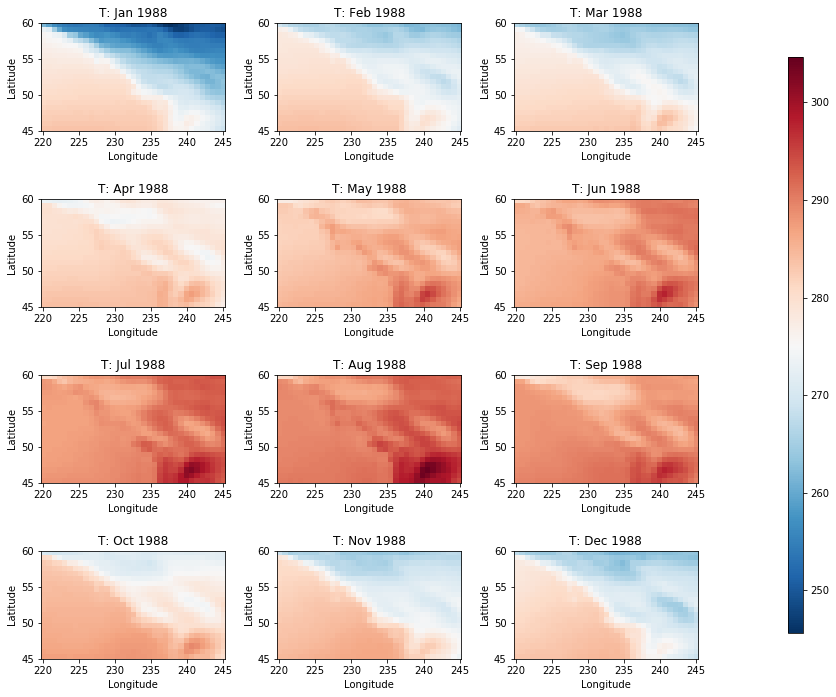

In [122]:
#plot temp for each month in 1997, since this year had a strong El Nino event

vmin = np.min([T[12*18+month,:,:] for month in range(12)])
vmax = np.max([T[12*18+month,:,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    #ax.set_axis_off()
    im = ax.imshow(np.asarray(np.squeeze(T[12*18+month,:,:])), extent=T_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('T: ' + months[month] +' 1997')
    #plt.colorbar()
    plt.tight_layout()
    month+=1
    
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

Preprocessing: remove seasonal cycle and apply 3-month running mean -- we want smoothed anomalies!



In [138]:
#remove last 7 months from 2017, so the timeseries line up
T_cut = T[:-7]
T2d_cut = T2d[:,:-7]

#calculate seasonal signal for each grid point
nyears = 38
T2d_seasonal = np.empty((np.shape(T2d)[0],12))
for ii in range(len(T2d_cut)):
    T2d_seasonal[ii,:] = np.mean(np.reshape(T2d_cut[ii,:],(nyears,12)),axis=0)

#repeat the seasonal cycle for all years
T2d_seasonal_all = np.tile(T2d_seasonal,(1,nyears))

#remove seasonal cycle from the original data (calculate anomalies)
T2d_anomalies = T2d_cut - T2d_seasonal_all

#apply 3-month running mean on each grid point 
T2d_anomalies_smooth = np.empty_like(T2d_anomalies)
N=3 #length of moving window
for ii in range(len(T2d_anomalies)):
    x=T2d_anomalies[ii,:]
    T2d_anomalies_smooth[ii,:] = np.convolve(x, np.ones((N,))/N, mode='same')


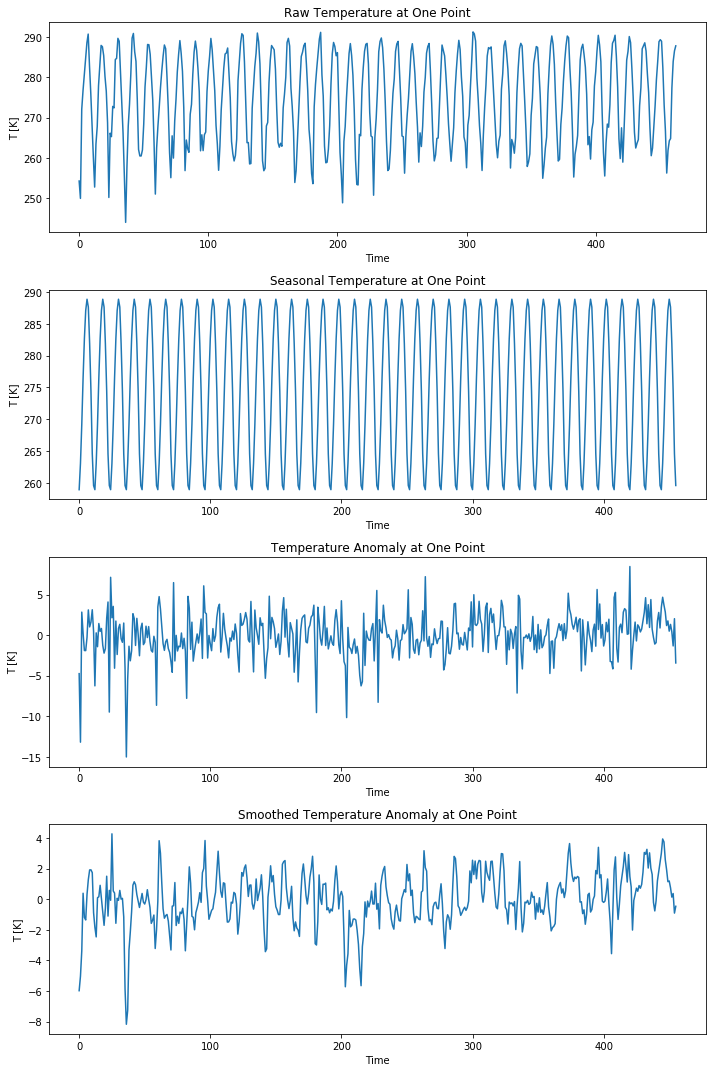

In [142]:
#let's visualize all of these great pre-processing steps!

gridIndex = 50 #arbitrary grid point to visualize the preprocessing for

plt.figure(figsize=(10,15))

plt.subplot(4,1,1)
plt.plot(T2d[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('T [K]')
plt.title('Raw Temperature at One Point')

plt.subplot(4,1,2)
plt.plot(T2d_seasonal_all[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('T [K]')
plt.title('Seasonal Temperature at One Point')

plt.subplot(4,1,3)
plt.plot(T2d_anomalies[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('T [K]')
plt.title('Temperature Anomaly at One Point')

plt.subplot(4,1,4)
plt.plot(T2d_anomalies_smooth[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('T [K]')
plt.title('Smoothed Temperature Anomaly at One Point')

plt.tight_layout()
plt.show()


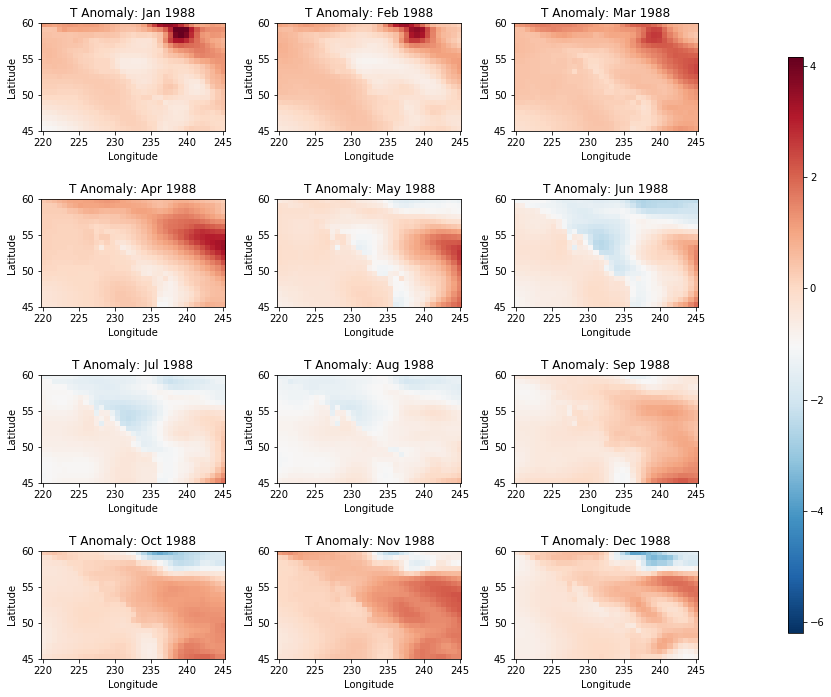

In [153]:
#plot the 3-month running mean of residuals for all grid points for all months of 1988

vmin = np.min([T2d_anomalies_smooth[12*9+month,:] for month in range(12)])
vmax = np.max([T2d_anomalies_smooth[12*9+month,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    #ax.set_axis_off()
    im = ax.imshow(np.asarray(np.reshape(T2d_anomalies_smooth[:,12*9+month],(21,35))), extent=T_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('T Anomaly: ' + months[month] +' 1988')
    #plt.colorbar()
    plt.tight_layout()
    month+=1
    
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

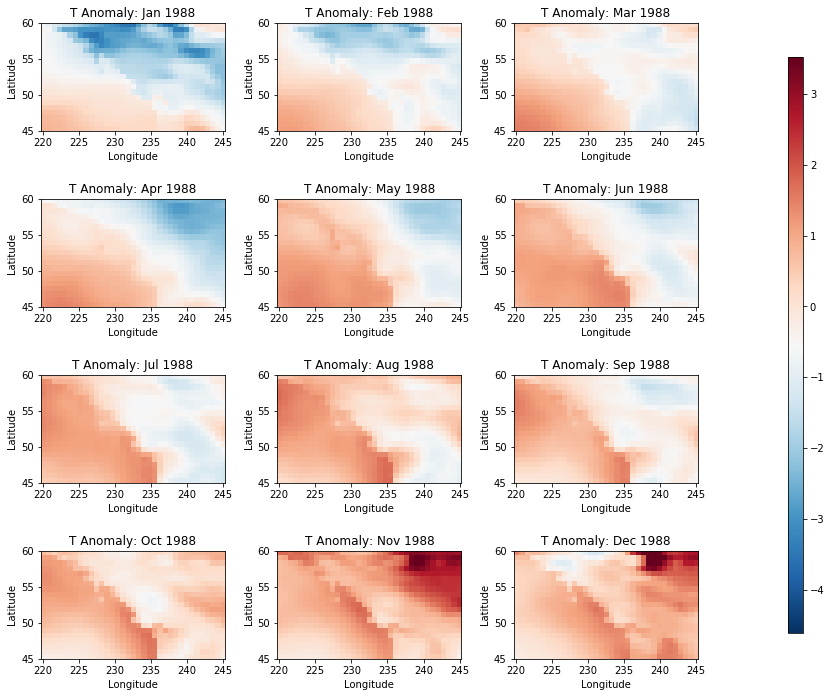

In [152]:
#plot the 3-month running mean of residuals for all grid points for all months of 1988

vmin = np.min([T2d_anomalies_smooth[12*18+month,:] for month in range(12)])
vmax = np.max([T2d_anomalies_smooth[12*18+month,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    #ax.set_axis_off()
    im = ax.imshow(np.asarray(np.reshape(T2d_anomalies_smooth[:,12*18+month],(21,35))), extent=T_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('T Anomaly: ' + months[month] +' 1997')
    #plt.colorbar()
    plt.tight_layout()
    month+=1
    
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

SOLUTIONS

Perform PCA on T anomaly data to find spatial modes

In [158]:
#do PCA using built-in library

data = T2d_anomalies_smooth.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(data)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

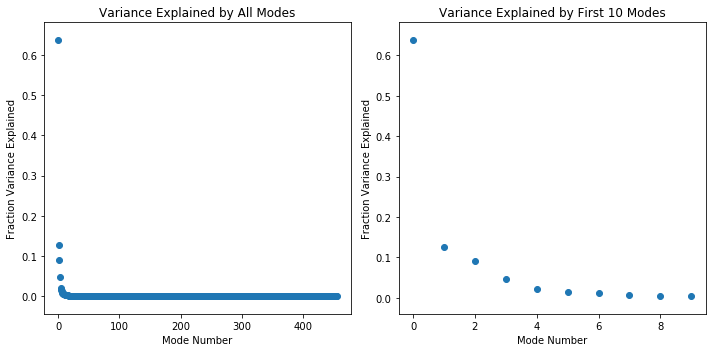

In [159]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()

plt.show()

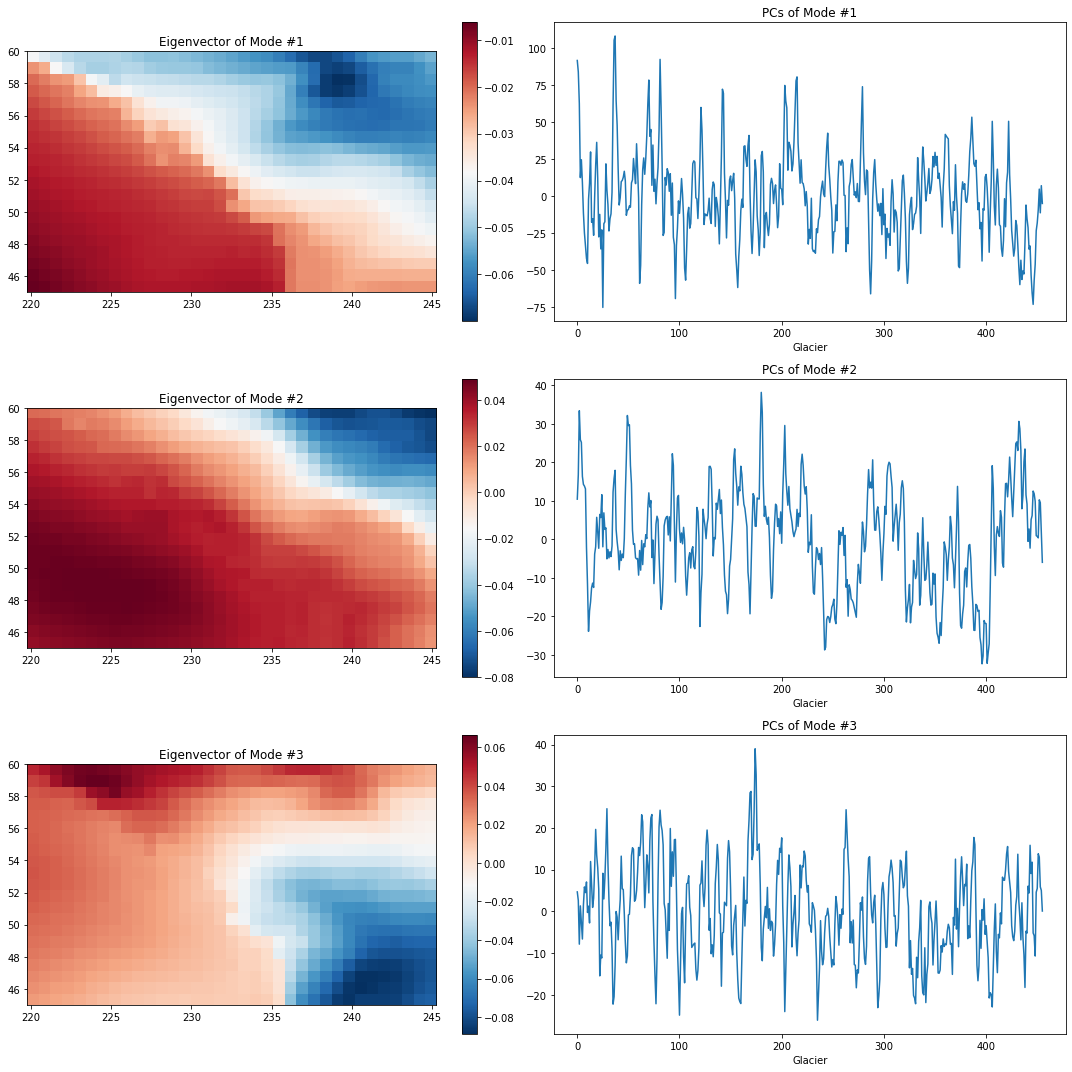

In [167]:
#plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure!

n = 3

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.imshow(np.reshape(eigvecs[kk,:],(21,35)),extent=T_extent,cmap = 'RdBu_r')
    plt.title('Eigenvector of Mode #' + str(kk+1))
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Glacier')
    
    plt.tight_layout()

Now, do CCA:

In [178]:
#
xdata = dataSST[:-4]
ydata = T2d_anomalies_smooth

In [174]:
np.shape(dataSST)

(460, 3915)

In [176]:
np.shape(dataSST[:-4])

(456, 3915)